In [127]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.util import MLUtils
from pyspark.ml.feature import VectorAssembler
from sklearn.metrics import confusion_matrix
from pyspark.sql.functions import when
import pandas as pd 

In [128]:
config = SparkConf()
spark = SparkSession.builder.master("local").appName("test").config(conf=config).getOrCreate()

In [129]:
# Preparing the train
train = spark.read.option("header", "true").csv(r"data\train.csv")
# filtre et supprime les données "NA"
train = train.filter(train.Age != "NA")
train = train.withColumn("Gender", when(train.Sex == "male","1").when(train.Sex == "female","2"))
# Supprime les colonnes inutiles
cols = ('SibSp', 'Parch', 'Fare', 'Ticket' ,'Cabin', 'Embarked', 'Name', 'Sex')
train = train.drop(*cols)

train.show(10)

+-----------+--------+------+---+------+
|PassengerId|Survived|Pclass|Age|Gender|
+-----------+--------+------+---+------+
|          1|       0|     3| 22|     1|
|          2|       1|     1| 38|     2|
|          3|       1|     3| 26|     2|
|          4|       1|     1| 35|     2|
|          5|       0|     3| 35|     1|
|          7|       0|     1| 54|     1|
|          8|       0|     3|  2|     1|
|          9|       1|     3| 27|     2|
|         10|       1|     2| 14|     2|
|         11|       1|     3|  4|     2|
+-----------+--------+------+---+------+
only showing top 10 rows



In [130]:
from pyspark.sql.types import IntegerType
from pyspark.sql.types import FloatType

train = train.withColumn("PassengerId", train["PassengerId"].cast('float'))
train = train.withColumn("Survived" ,train["Survived"].cast('float'))
train = train.withColumn("Pclass" ,train["Pclass"].cast('float'))
train = train.withColumn("Age" ,train["Age"].cast(('float')))
train = train.withColumn("Gender" ,train["Gender"].cast(('float')))
train.printSchema()
features = ['Pclass','Age', 'Gender']
va = VectorAssembler(inputCols = features, outputCol='features')
va_df = va.transform(train)
va_df.show(3)

root
 |-- PassengerId: float (nullable = true)
 |-- Survived: float (nullable = true)
 |-- Pclass: float (nullable = true)
 |-- Age: float (nullable = true)
 |-- Gender: float (nullable = true)

+-----------+--------+------+----+------+--------------+
|PassengerId|Survived|Pclass| Age|Gender|      features|
+-----------+--------+------+----+------+--------------+
|        1.0|     0.0|   3.0|22.0|   1.0|[3.0,22.0,1.0]|
|        2.0|     1.0|   1.0|38.0|   2.0|[1.0,38.0,2.0]|
|        3.0|     1.0|   3.0|26.0|   2.0|[3.0,26.0,2.0]|
+-----------+--------+------+----+------+--------------+
only showing top 3 rows



In [131]:
(train_, test) = va_df.randomSplit([0.8, 0.2])

In [132]:
from pyspark.ml.feature import StringIndexer

dtc = DecisionTreeClassifier(featuresCol="features", labelCol="Survived")

#indexer = StringIndexer().setInputCol("Survived").setOutputCol("label_idx").fit(train_)

prediction = dtc.fit(train_) #dtc.setLabelCol("label_idx").fit(dtc)

prediction

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_65ab854fc833, depth=5, numNodes=25, numClasses=2, numFeatures=3

In [133]:
pred = prediction.transform(test)
pred = pred.withColumnRenamed('Survived', 'label')
pred.show(3)

+-----------+-----+------+----+------+--------------+-------------+--------------------+----------+
|PassengerId|label|Pclass| Age|Gender|      features|rawPrediction|         probability|prediction|
+-----------+-----+------+----+------+--------------+-------------+--------------------+----------+
|        9.0|  1.0|   3.0|27.0|   2.0|[3.0,27.0,2.0]|  [21.0,32.0]|[0.39622641509433...|       1.0|
|       10.0|  1.0|   2.0|14.0|   2.0|[2.0,14.0,2.0]|   [4.0,50.0]|[0.07407407407407...|       1.0|
|       16.0|  1.0|   2.0|55.0|   2.0|[2.0,55.0,2.0]|    [1.0,1.0]|           [0.5,0.5]|       0.0|
+-----------+-----+------+----+------+--------------+-------------+--------------------+----------+
only showing top 3 rows



In [134]:
evaluator=MulticlassClassificationEvaluator(predictionCol="prediction")
acc = evaluator.evaluate(pred)

print("Prediction Accuracy: ", acc*100)

y_pred=pred.select("prediction").collect()
y_orig=pred.select("label").collect()

confusion_M = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(confusion_M)

Prediction Accuracy:  76.53181659791149
Confusion Matrix:
[[73 14]
 [19 36]]


In [135]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_orig, y_pred))

              precision    recall  f1-score   support

         0.0       0.79      0.84      0.82        87
         1.0       0.72      0.65      0.69        55

    accuracy                           0.77       142
   macro avg       0.76      0.75      0.75       142
weighted avg       0.77      0.77      0.77       142



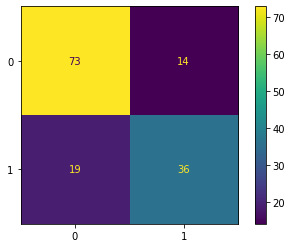

In [136]:
from sklearn.metrics import ConfusionMatrixDisplay
import traceback
import logging
try:
    cm = confusion_matrix(y_orig, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dtc)
    disp.plot()
except Exception as e:
    print("")
    #logging.error(traceback.format_exc())

In [137]:
#from dtreeviz import trees
#from sklearn import tree
#from dtreeviz.trees import dtreeviz
#train.show(1)
#trees.dtreeviz(dtc.fit(train), fancy=True)
#feature_cols = ['PassengerId', 'Survived','Pclass', 'Age', 'Gender']

In [138]:
#import graphviz
#print(graphviz.__version__)
#graphviz_tree = tree.export_graphviz(iowa_model, out_file=None, feature_names=features, filled=True)
#graphviz.Source(graphviz_tree, format="png") 

In [139]:
spark.stop()

In [140]:
#from io import StringIO
#from IPython.display import Image  
#import pydotplus
#from sklearn.tree import export_graphviz

#feature_cols = ['PassengerId', 'Survived','Pclass', 'Age', 'Gender']

#dot_data = StringIO()
#export_graphviz(dtc.fit(train), out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names = feature_cols, class_names=['0','1'])
#graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#graph.write_png('tree-spark.png')
#Image(graph.create_png())

In [141]:
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.tree import _tree
import numpy as np
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules

In [142]:
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.tree import _tree

feature_cols = ['PassengerId', 'Survived','Pclass', 'Age', 'Gender']

rules = get_rules(dtc, feature_cols, None)
for r in rules:
    d = pd.DataFrame(data=rules)
d.tail()

AttributeError: 'DecisionTreeClassifier' object has no attribute 'tree_'